### 1. Import Library

In [1]:
# !pip install -r requirements.txt

In [2]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import random
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.graph_objs as go

In [3]:
# 난수 생성 고정
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

### 2. Load Train Data & Test Data

In [4]:
# 데이터 경로 설정
DATA_PATH = Path("./data")

In [5]:
train_data = pd.read_csv(DATA_PATH / "train.csv")
test_data = pd.read_csv(DATA_PATH / "test.csv")

In [6]:
# 필요 피처 선택
non_numeric_cols = ["faultNumber", "simulationRun", "sample"]
use_cols = train_data.columns.difference(non_numeric_cols)

X_train = train_data[use_cols]
X_test = test_data[use_cols]

In [7]:
print(len(X_train.columns))
print(len(X_test.columns))

52
52


In [8]:
# 필요한 라이브러리 임포트 
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from torch.utils.data import DataLoader, TensorDataset 
import torch

# 데이터 스케일러 인스턴스 생성(데이터 표준화)
## 어떤 스케일러를 적용해야하는가?
# scaler = MinMaxScaler()
scaler = RobustScaler() 
# 학습 데이터셋에 대해 fit과 transform 수행: train 기준 정보 계산 및 데이터 변환
X_train_scaled = scaler.fit_transform(X_train) 
# 테스트 데이터셋에 대해서는 transform만 수행: 학습 데이터셋의 기준 정보를 사용하여 데이터 변환
X_test_scaled = scaler.transform(X_test)  

# PyTorch Tensor로 변환 
X_train_tensor = torch.FloatTensor(X_train_scaled) 
X_test_tensor = torch.FloatTensor(X_test_scaled)  

# DataLoader 설정 
train_dataset = TensorDataset(X_train_tensor, X_train_tensor) # 입력과 타겟이 같음 
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, X_test_tensor) # 입력과 타겟이 같음 
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [9]:
print(len(train_dataset))
print(len(test_dataset))

250000
710400


In [10]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
for data in test_loader:
    inputs = data[0]
    break

print(inputs.shape)

torch.Size([1, 52])


### 3. Autoencoder 구현

In [11]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # 인코더 구성
        ## 적절한 차원의 차수는?
        ## trial-1: 52 > 32 > 16
        ## trial-2: 52 > 32 > 16 > 8
        self.encoder = nn.Sequential(
            nn.Linear(52, 32), # 입력 차원 52에서 낮은 차수의 중간 차원 32로 압축
            nn.ReLU(), # 활성화 함수 ReLU 사용
            nn.Linear(32, 16), # 중간 차원 32에서 특징 차원 16으로 더 압축
            nn.ReLU(), # 활성화 함수 ReLU 사용
        )
        # 디코더 구성
        self.decoder = nn.Sequential(
            nn.Linear(16, 32), # 특징 차원 16에서 중간 차원 32으로 확장
            nn.ReLU(), # 활성화 함수 ReLU 사용
            nn.Linear(32, 52), # 중간 차원 32에서 원본 차원인 55로 복원
            nn.Sigmoid() # 출력을 0과 1 사이로 조정
        )

    def forward(self, x):
        x = self.encoder(x) # 인코딩
        x = self.decoder(x) # 디코딩
        return x

### 4. Model Traning

In [12]:
model = Autoencoder()
criterion = nn.MSELoss() # MSE: Mean Squared Error 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Adam optimizer

for epoch in range(100):
    for data in train_loader:
        inputs = data[0]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.8207340836524963
Epoch 1, Loss: 0.7897583842277527
Epoch 1, Loss: 0.7855383157730103
Epoch 1, Loss: 0.792754054069519
Epoch 1, Loss: 0.8051061034202576
Epoch 1, Loss: 0.7939802408218384
Epoch 1, Loss: 0.8123992085456848
Epoch 1, Loss: 0.8044755458831787
Epoch 1, Loss: 0.7961654663085938
Epoch 1, Loss: 0.7966810464859009
Epoch 1, Loss: 0.7895455956459045
Epoch 1, Loss: 0.7873722910881042
Epoch 1, Loss: 0.7950710654258728
Epoch 1, Loss: 0.7866764664649963
Epoch 1, Loss: 0.7795100808143616
Epoch 1, Loss: 0.7834883332252502
Epoch 1, Loss: 0.7930690050125122
Epoch 1, Loss: 0.7929680347442627
Epoch 1, Loss: 0.7681900858879089
Epoch 1, Loss: 0.7960396409034729
Epoch 1, Loss: 0.7832043766975403
Epoch 1, Loss: 0.7872158885002136
Epoch 1, Loss: 0.7854959964752197
Epoch 1, Loss: 0.7729505896568298
Epoch 1, Loss: 0.7554478049278259
Epoch 1, Loss: 0.7579208016395569
Epoch 1, Loss: 0.7820030450820923
Epoch 1, Loss: 0.759411096572876
Epoch 1, Loss: 0.76341712474823
Epoch 1, Loss: 0.7

In [13]:
model_name = "exp1"
torch.save(model.state_dict(), f"./model_{model_name}.pt")

### 5. Model Inference

In [14]:
model.load_state_dict(torch.load("./model_exp1.pt"))

/tmp/ipykernel_625558/2685689877.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./model_exp1.pt"))


<All keys matched successfully>

In [15]:
model.eval()

batch_size = len(train_dataset)
infer_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for data in infer_train_loader:
        inputs = data[0]
        outputs = model(inputs)

In [16]:
 # reconstruction error 계산 
train_reconstruction_errors = torch.mean((outputs - inputs) ** 2, axis=1)  #MSE
print(train_reconstruction_errors)

df_train_reconstruction_errors = pd.DataFrame(train_reconstruction_errors.detach().numpy(), columns=["error"])
print(type(df_train_reconstruction_errors))
print(df_train_reconstruction_errors.shape)

max_error = df_train_reconstruction_errors["error"].max()
print(type(max_error))
print(max_error)

tensor([0.0493, 0.1199, 0.2031,  ..., 0.2429, 0.3657, 0.3904])
<class 'pandas.core.frame.DataFrame'>
(250000, 1)
<class 'float'>
1.7295613288879395


In [17]:
df_train_reconstruction_errors.describe()

error
count  250000.000000
mean        0.367995
std         0.132453
min         0.016031
25%         0.275933
50%         0.346082
75%         0.435635
max         1.729561

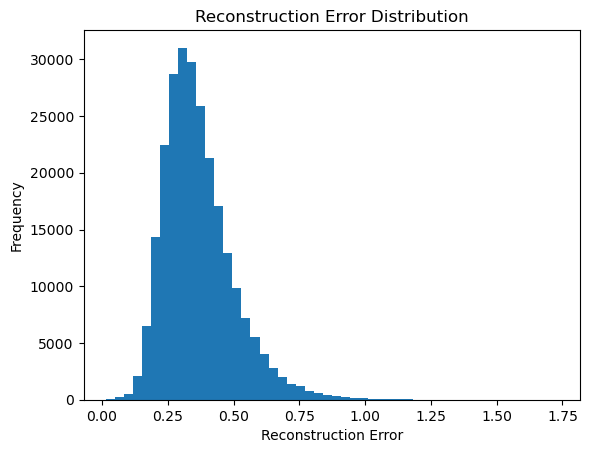

In [18]:
# reconstruction error 히스토그램 시각화 
plt.hist(train_reconstruction_errors.detach().numpy(), bins=50) 
plt.xlabel('Reconstruction Error') 
plt.ylabel('Frequency') 
plt.title('Reconstruction Error Distribution')

plt.show()

In [19]:
model.eval()

batch_size = len(test_dataset)
infer_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for data in infer_test_loader:
        inputs = data[0]
        outputs = model(inputs)

In [20]:
# reconstruction error 계산 
test_reconstruction_errors = torch.mean((outputs - inputs) ** 2, axis=1)  #MSE
print(test_reconstruction_errors)

df_test_reconstruction_errors = pd.DataFrame(test_reconstruction_errors.detach().numpy(), columns=["error"])
print(type(df_test_reconstruction_errors))
print(df_test_reconstruction_errors.shape)

tensor([9.1902e-02, 1.4540e-01, 2.5824e-01,  ..., 4.6043e+02, 4.6155e+02,
        4.6155e+02])
<class 'pandas.core.frame.DataFrame'>
(710400, 1)


In [21]:
df_test_reconstruction_errors.describe()

error
count  710400.000000
mean       13.438677
std        70.601624
min         0.019244
25%         0.298202
50%         0.389475
75%         0.572402
max       646.915588

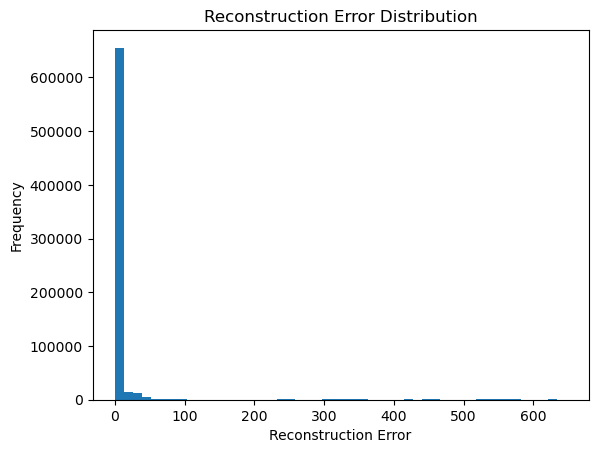

In [22]:
# reconstruction error 히스토그램 시각화 
plt.hist(test_reconstruction_errors.detach().numpy(), bins=50) 
plt.xlabel('Reconstruction Error') 
plt.ylabel('Frequency') 
plt.title('Reconstruction Error Distribution')

plt.show()

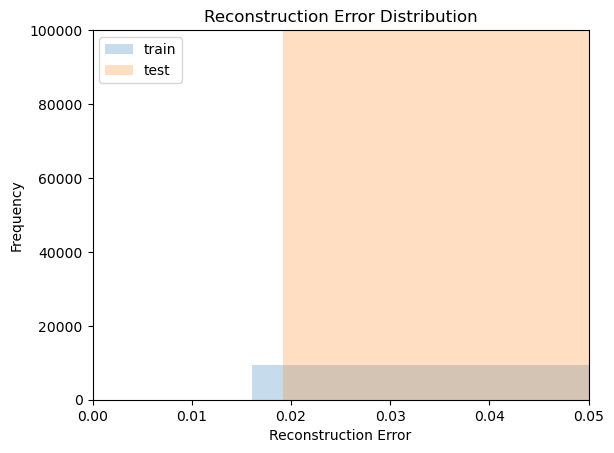

In [23]:
# reconstruction error 히스토그램 시각화
plt.hist(train_reconstruction_errors.detach().numpy(), alpha=0.25, label="train")
plt.hist(test_reconstruction_errors.detach().numpy(), alpha=0.25, label="test")
plt.xlim((0, 0.05))
plt.ylim((0, 100000))
plt.xlabel('Reconstruction Error') 
plt.ylabel('Frequency') 
plt.title('Reconstruction Error Distribution')
plt.legend()

plt.show()

In [24]:
# threshold = max_error + max_error * 0.1

- [01] threshold = 0.016887
- [02] threshold = 0.016769 + (0.016769) * 0.1
- [03] threshold = 0.017843 + (0.017843) * 0.2

In [ ]:
# threshold = np.mean(df_train_reconstruction_errors["error"]) + np.std(df_train_reconstruction_errors["error"])

In [25]:
threshold = np.mean(df_train_reconstruction_errors["error"]) + 3 * np.std(df_train_reconstruction_errors["error"])
print("threshold: ", threshold)

threshold:  0.7653539180755615


- Initial
    - batchsize=64
    - epoch=20
- [04] threshold:  0.008588183671236038
- [05] threshold:  0.01129639009013772
- [06] threshold:  0.5062470883131027
    - batchsize=256
    - epoch=100
- [07] threshold:  0.7653539180755615
    - threshold = np.mean(df_train_reconstruction_errors["error"]) + 3 * np.std(df_train_reconstruction_errors["error"]): 3 곱하기 표준편차

In [26]:
df = df_test_reconstruction_errors.copy()

df["faultNumber"] = 0
df.loc[df["error"] > threshold, "faultNumber"] = 1

df_output = df.drop("error", axis=1)

In [27]:
df_output.value_counts()

faultNumber
0              578312
1              132088
Name: count, dtype: int64

In [28]:
from datetime import datetime

# CSV 파일로 저장
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"output_{current_time}.csv"
df_output.to_csv(filename)

In [29]:
print(threshold)

0.7653539180755615
